# CoolMPM: A Total Lagrangian MPM Code

A Dynamic Explicit Total Lagrangian MPM for Large Deformation in 1D

Code developed by Jacob Nuttall

10 March 2025

# MIT License
Copyright (c) 2025 Jacob Nuttall

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
THE SOFTWARE.

In [1]:
from tlmpm.tlmpm import initialize_grid, initialize_particles, extrapolate_quantity_p2g, TotalLagrangianMPM, select_data
from tlmpm.configuration_plot import plot_configuration, draw_rectangle
import pandas as pd

In [2]:
import numpy as np
from IPython import display
import time
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import matplotlib.colors as mcolors 


# Auxiliary Functions

## Strain Energy Density and Second PK Stress

In [3]:
def SPK_stress(defgrad, params):
    mu = params['mu']
    dlambda = params['dlambda']
    J = defgrad
    right_CG = defgrad*defgrad
    C_inv = 1/right_CG
    S11 =  mu + (dlambda*np.log(J) - mu)*C_inv
    return S11

In [4]:
def Strain_Energy_Density(F11, params):
    dlambda = params['dlambda']
    mu = params['mu']
    return 0.5*dlambda*np.log(F11)**2 - mu*np.log(F11) + 0.5*mu*(F11**2 - 1)

# Verification

## Verification Problem 1: Large deformation of a Hyperelastic Column

In [5]:
fem_data = pd.read_csv('./data/1d-fem-10el-2ip.csv')

### Parameters

None

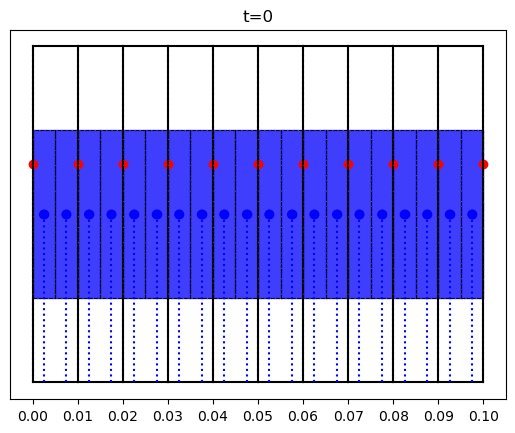

In [6]:
# Initialize parameters
E = 5e3 
nu = 0.3 
L = 0.1
A = 1e-4 
rho = 10 
mu = E/(2*(1+nu))
dlambda = 2*mu*nu/(1 - 2*nu)
Kbulk = dlambda + 2*mu/3 
wavespeed = np.sqrt(E/rho)
dtfactor=0.1
t_tot = 1.2
t_ramp = 1.0
n_cells = 10
n_en = 2
n_ppc = 2
b = lambda t : -9.81
tau0 = -1e4
def tau(t):
    if t < t_ramp:
        return tau0*(t/t_ramp)
    return tau0 
alpha=0.5
params = dict(E=E,nu=nu,mu=mu,dlambda=dlambda,Kbulk=Kbulk,
              rho=rho,b=b,tau=tau,L=L,A=A,wavespeed=wavespeed,)

# Make grid plot
grid = initialize_grid(params, n_cells, n_ppc, n_en)
particles = initialize_particles(params, grid)
fig = plt.figure()
hdisplay = display.display(None, display_id=True)
ax = plt.gca()
plt.title('t=0')
plot_configuration(ax, particles, grid, fig, hdisplay, params)

### Solution

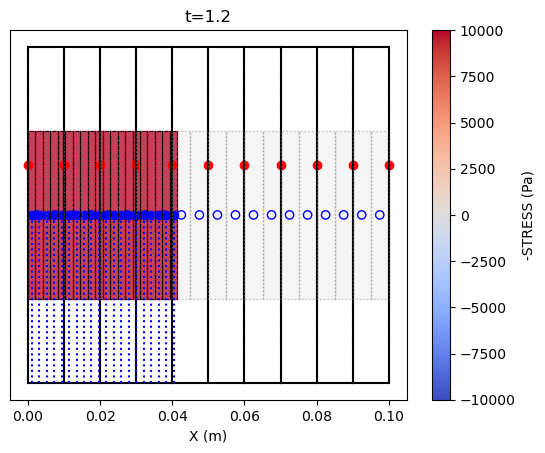

C:\Users\Jacob Nuttall\AppData\Local\Temp\ipykernel_36072\1631428871.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(cmap)


In [7]:
# Reset problem domain
grid = initialize_grid(params, n_cells, n_ppc, n_en)
particles = initialize_particles(params, grid)

# Initialize plots
fig = plt.figure() #dpi=300)
hdisplay = display.display(None, display_id=True)
plt.title('t=0')
plot_configuration(ax, particles, grid, fig, hdisplay, params,)
ax = plt.gca()

# Dummy plot to add a colorbar to axis
x = y = np.linspace(0,1,10)
x, y = np.meshgrid(x,y)
plt.sca(ax)
plt.contourf(x,y,x,cmap='Spectral')
cbar = plt.colorbar()
label='-STRESS (Pa)'
cmap = 'coolwarm'
colormap = cm.get_cmap(cmap)

# +/- stress value for colorbar
maxstress = 1e4
update_stress= False

def plot_func(t, k):
    global fig, ax, maxstress, cbar, hdisplay, update_stress
    ax.clear()

    # Update stress values if specified
    stress = -np.array(particles['stress'])
    if update_stress:
        maxstress = np.max((np.max(np.abs(stress)), maxstress))
    else: maxstress = maxstress

    norm = mcolors.Normalize(-maxstress, maxstress)   
    sm = cm.ScalarMappable(cmap=colormap, norm=norm)
    plt.colorbar(sm, cbar.ax)     
    plt.sca(ax)
    cbar.set_label(label)
    
    ax.set_title('t='+str(round(t,3)))
    plot_configuration(ax,
        particles, 
        grid, fig, 
        hdisplay, params, True, 
        cmin=-maxstress, cmax=maxstress, 
        Qp=stress, cbar=cbar, cmap='coolwarm', label=label,
        show_labels=False, draw_nodes=True,draw_rect=True,)
    
    # draw_rectangle(ax, 0,L,-0.5*np.sqrt(A),0.5*np.sqrt(A),color='k')
    ax.set_xlabel('X (m)')
    ax.set_xticks(np.linspace(0,L,6))
    hdisplay.update(fig)    
    
    
grid, particles, particle_history = TotalLagrangianMPM(
     particles, grid, params, SPK_stress, 
     alpha, dtfactor, t_tot,
      plot=True, plot_func=plot_func, nplots=100)

plt.close()

### Stress vs. time

Text(0, 0.5, '-sig$_{11}$ (Cauchy Stress, Pa)')

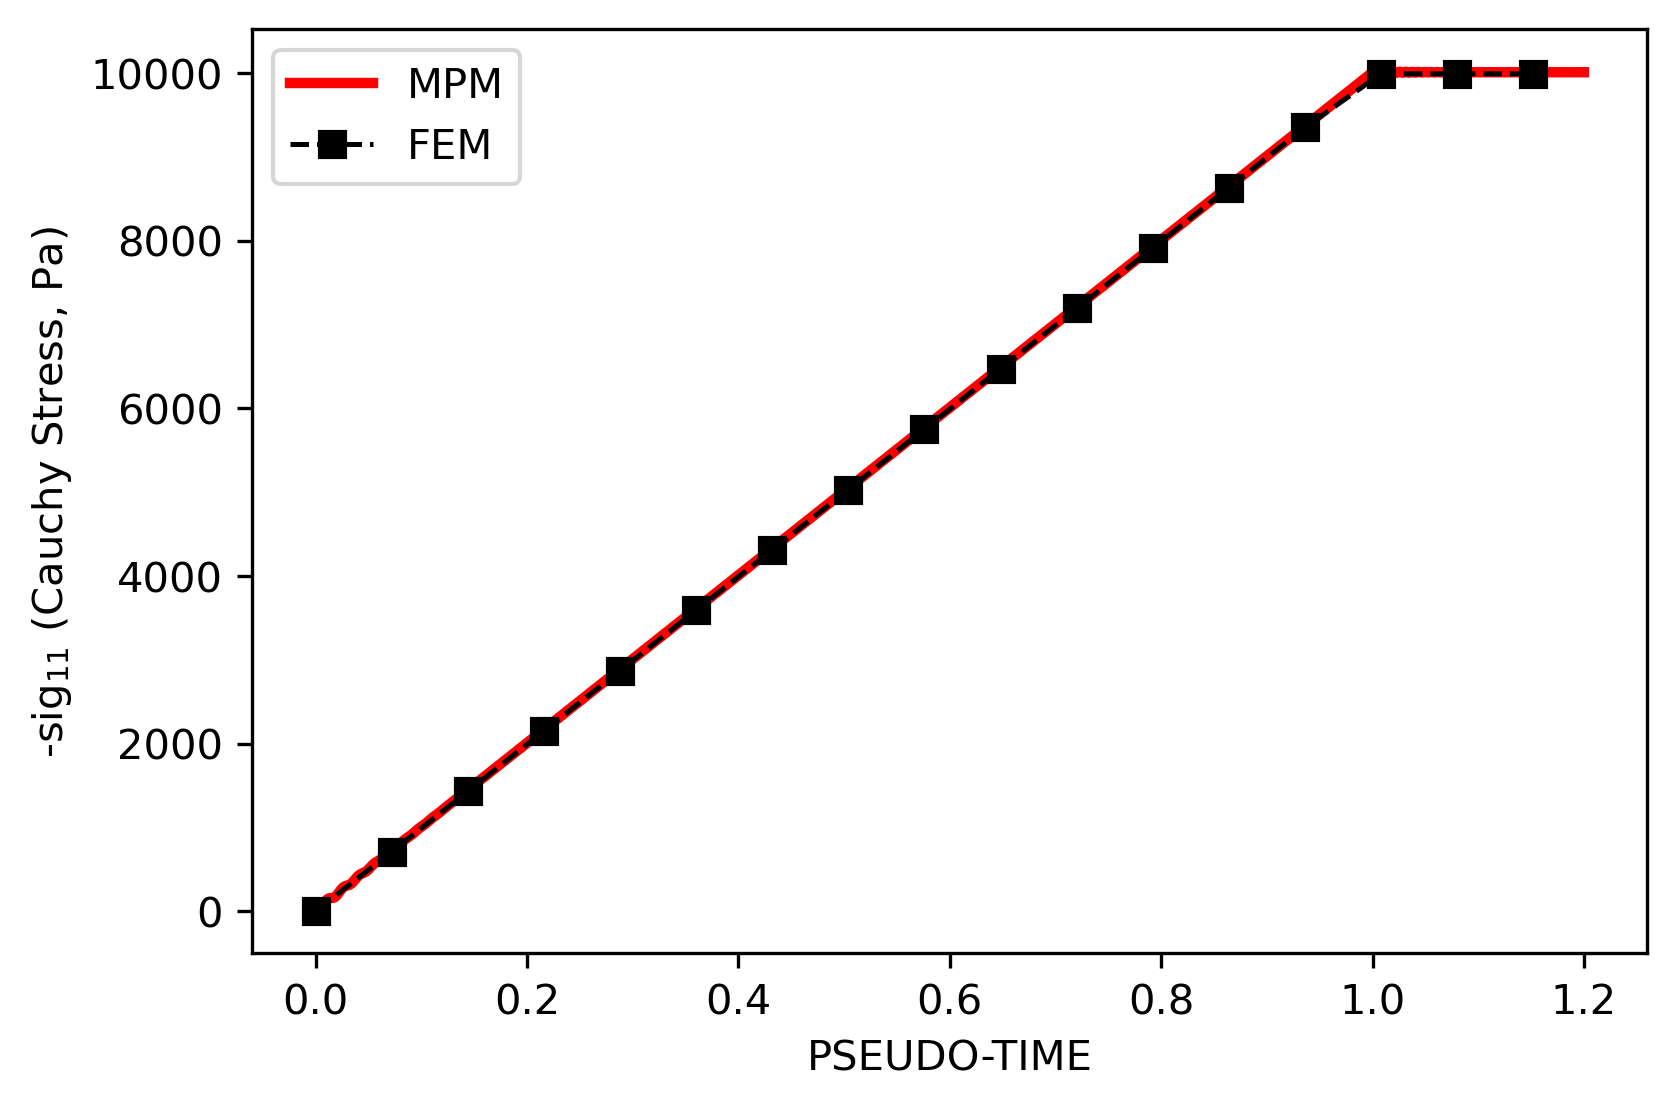

In [8]:
E11, le11, e11, sig11, S11, ts, xs, Xs, dXs, dxs = select_data(particle_history, 0)
plot_kwargs_mpm = dict(color='r',linewidth=2.5)
plt.figure(figsize=(6,4), dpi=300)

plt.plot(ts, -sig11, label='MPM', **plot_kwargs_mpm)
plot_kwargs_fem = dict(label='FEM',linewidth=1.2, color='k')
plt.plot(fem_data['t'][::3], fem_data['sig11'][::3], 's--', **plot_kwargs_fem)
plt.legend()
plt.xlabel('PSEUDO-TIME')
plt.ylabel('-sig$_{11}$ (Cauchy Stress, Pa)')

### Displacement vs. time

In [9]:
t_n = np.copy(particle_history['t'][:,0])
d_n = np.array([extrapolate_quantity_p2g(dxi, particles, grid) for dxi in particle_history['x']])
d_n = d_n - d_n[0]

Text(0.5, 0, 'PSEUDO-TIME')

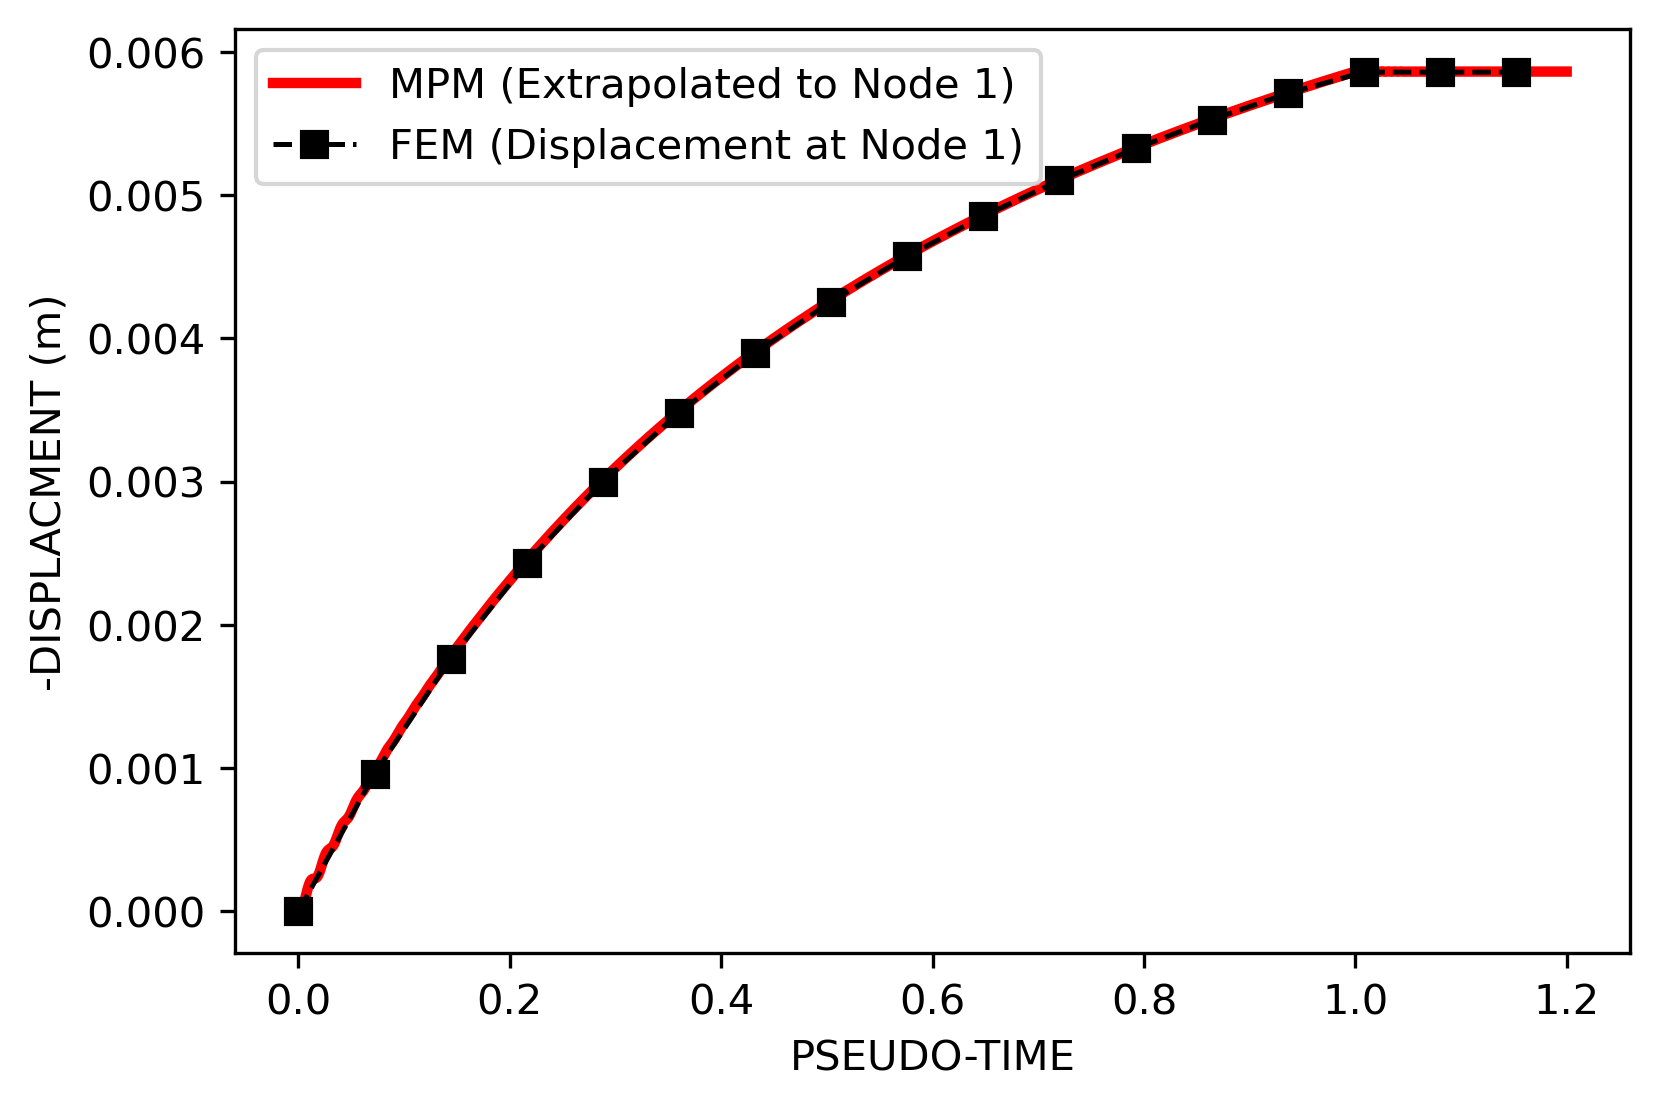

In [10]:
plot_kwargs_mpm = dict(color='r',linewidth=2.5)
plot_kwargs_fem = dict(linewidth=1.2, color='k')
plt.figure(figsize=(6,4), dpi=300)

plt.plot(t_n, -d_n[:,1], label='MPM (Extrapolated to Node 1)', **plot_kwargs_mpm)
plt.plot(fem_data['t'][::3], -fem_data['d'][::3], 's--', label='FEM (Displacement at Node 1)', **plot_kwargs_fem)
plt.legend()
plt.ylabel('-DISPLACMENT (m)')
plt.xlabel('PSEUDO-TIME')


### Stress vs. Strain

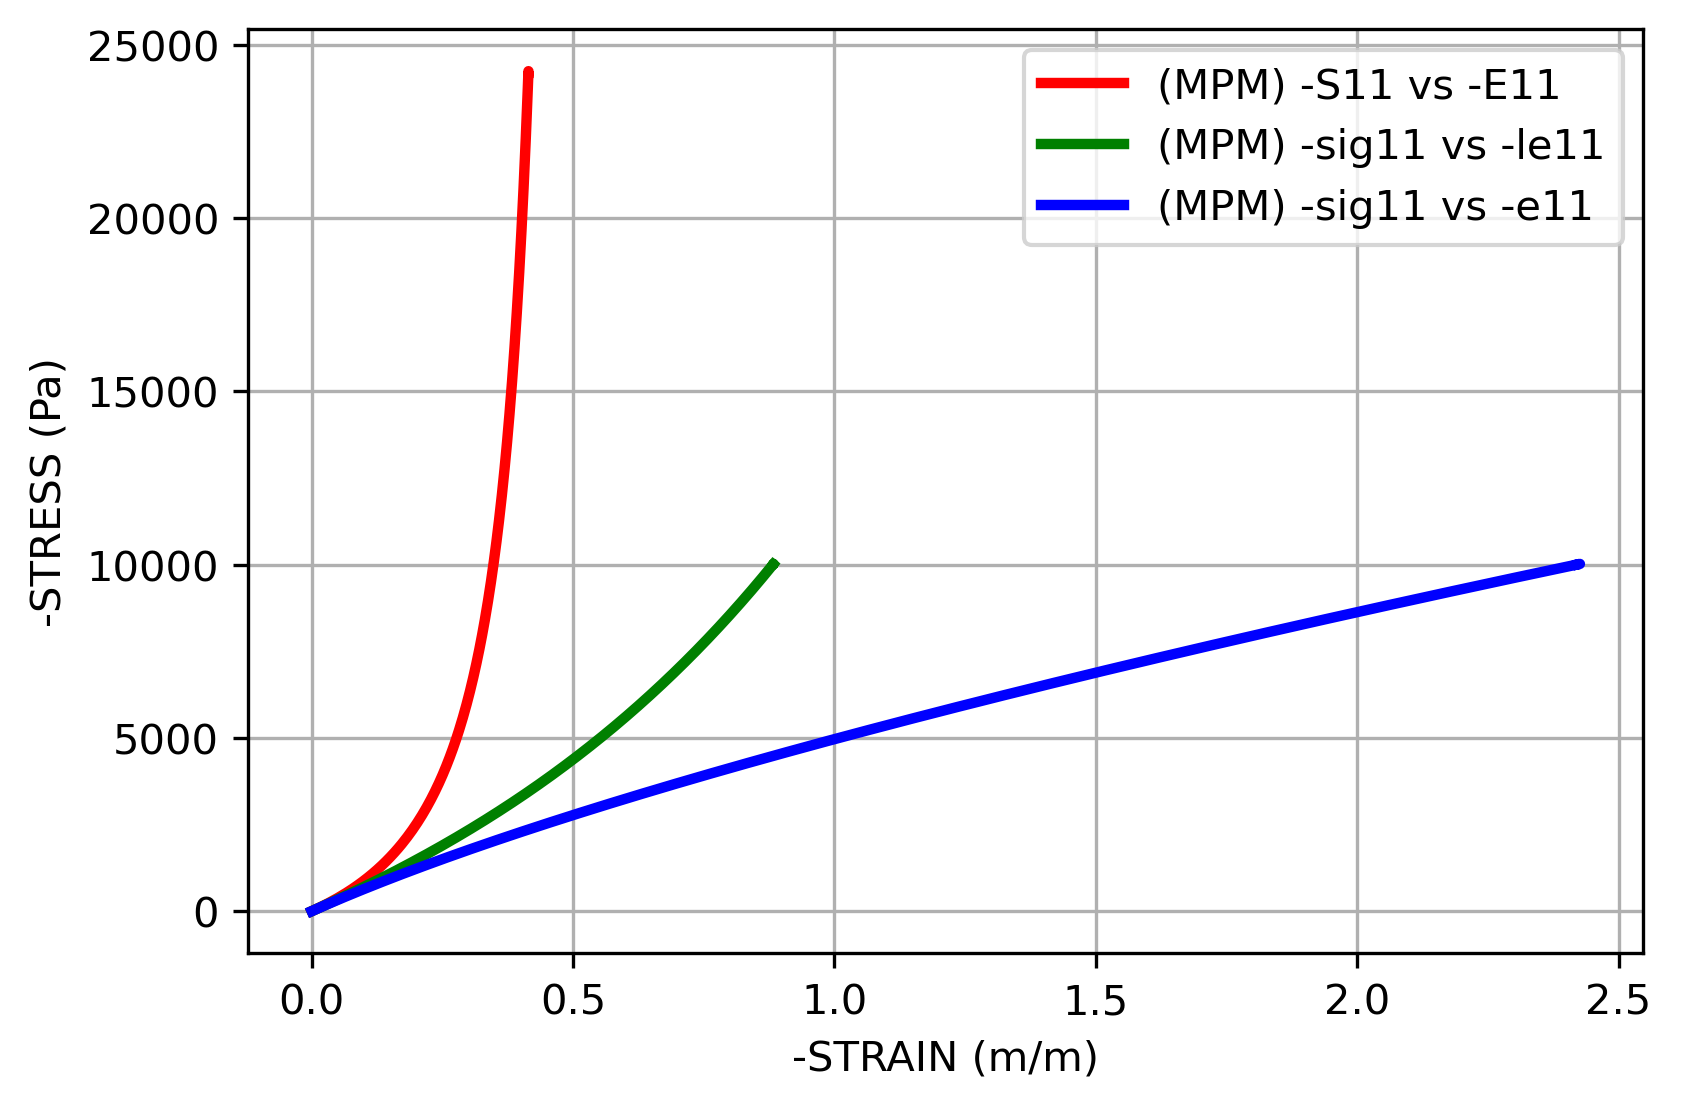

In [11]:
n = -1
plt.figure(figsize=(6,4), dpi=300)
plt.plot(-E11[0:n:100], -S11[0:n:100],  '-',color='r', linewidth=2.5,label='(MPM) -S11 vs -E11')
plt.plot(-le11[0:n:10], -sig11[0:n:10], '-', color='g', linewidth=2.5,label='(MPM) -sig11 vs -le11')
plt.plot(-e11[0:n:10], -sig11[0:n:10], '-', color='b',linewidth=2.5, label='(MPM) -sig11 vs -e11')
# plt.plot(fem_data['E11'][::4], fem_data['S11'][::4], 'o--', linewidth=1.2,color='k', label='(FEM) -S11  vs -E11')
# plt.plot(fem_data['le11'][::4], fem_data['sig11'][::4], '*--',  linewidth=1.2,color='k', label='(FEM) -sig11 vs -le11')
# plt.plot(fem_data['e11'][::4], fem_data['sig11'][::4], 's--',  linewidth=1.2,color='k', label='(FEM) -sig11 vs -e11')
plt.plot()
plt.xlabel('-STRAIN (m/m)')
plt.ylabel('-STRESS (Pa)')
plt.legend()
plt.grid()

plt.title('')
plt.show()

## Verification Problem 2: Dynamic Step Loading Bar

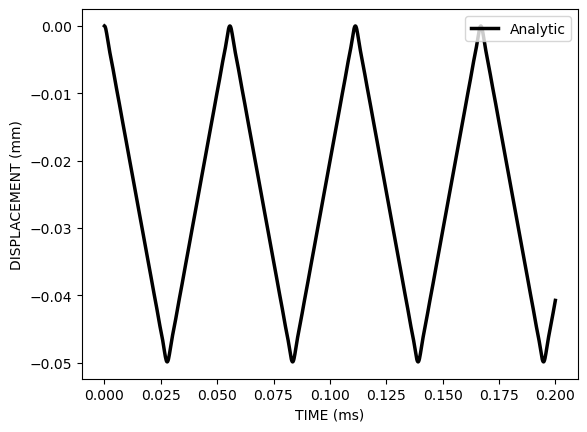

In [12]:
E = 250
nu = 0.0
mu = E/(2*(1+nu))
dlambda = 2*mu*nu/(1 - 2*nu)
Kbulk = dlambda + 2*mu/3 
rho = 1.935e-3 
L = 5e-3
A = 19.635 
P0 = -25 # N
tau = lambda t : P0/A
b = lambda t: 0
c = wavespeed = np.sqrt(E/rho)

dtfactor=0.2
T = 0.2e-3


n_cells = 10
n_en = 3
n_ppc = 2

params = dict(E=E,nu=nu,mu=mu,dlambda=dlambda,Kbulk=Kbulk,
              rho=rho,b=b,tau=tau,L=L,A=A,wavespeed=wavespeed,)
grid = initialize_grid(params, n_cells, n_ppc, n_en)
particles = initialize_particles(params, grid)

# fig = plt.figure()
# hdisplay = display.display(None, display_id=True)
# plt.title('t=0')
# plot_system(particles, grid, fig, hdisplay, params)
# plt.figure()

def analytic_displi(n,z,t):
    term1 = lambda k : np.sin((2*k-1)*((np.pi*z)/(2*L)))
    term2 = lambda k : 1 - np.cos((2*k-1)*(np.pi*c*t)/(2*L))
    term3 = lambda k : (-1)**(k-1)
    term4 = lambda k : (2*k-1)**2 
    _sum = 0
    for k in range(1,n+1):
        _sum += (term3(k)/term4(k))*term1(k)*term2(k)
    return 8*P0*L/(np.pi**2*E*A)*_sum 
        

at = np.linspace(0,0.2e-3,1000)
adispl = np.array([analytic_displi(10,L,ti) for ti in at])
plt.plot(at*1e3, adispl*1e3,  color='k', label='Analytic', linewidth=2.5)
plt.ylabel('DISPLACEMENT (mm)')
plt.xlabel('TIME (ms)')
plt.legend(bbox_to_anchor=(1,1),loc='upper right')

In [13]:
particle_data = []
grid_data = []
n_els = (2,5,10,15,20,25,30)
for n_el in n_els:
    grid = initialize_grid(params, n_cells=n_el, n_ppc=n_ppc, n_en=3)
    particles = initialize_particles(params, grid)
    grid_data.append(grid)

    particles, grid, particle_history = TotalLagrangianMPM(particles, grid, params, SPK_stress, alpha, dtfactor, T)
    particle_data.append(particle_history)

## Convergence Plot

In [14]:
errors = []
pid=-1
n_ppc =2 
nen = 3
for j, n_el in enumerate(n_els):
    cid=0
    displ=0
    particle_history = particle_data[j]
    for key, item in particle_history.items():
        particle_history[key] = np.array(item)
    particle_history['u'] = particle_history['x'] - particle_history['X']

    grid = initialize_grid(params, n_el, n_ppc, n_en)
    particles = initialize_particles(params, grid)

    # grid = grid_data[j]
    nnodes = grid['n_nodes']
    t_n = particle_history['t'][:,0].copy()
    u_ns = np.zeros((len(t_n),nnodes)) 
    m_n = np.zeros((len(t_n), nnodes))
    
    for i in range(len(t_n)):
        up = particle_history['u'][i]
        u_ns[i] = extrapolate_quantity_p2g(up, particles, grid)

    adispl2 = analytic_displi(10,5e-3,t_n)
    errors.append(np.sqrt(np.mean((u_ns[:,-1] - adispl2)**2)))


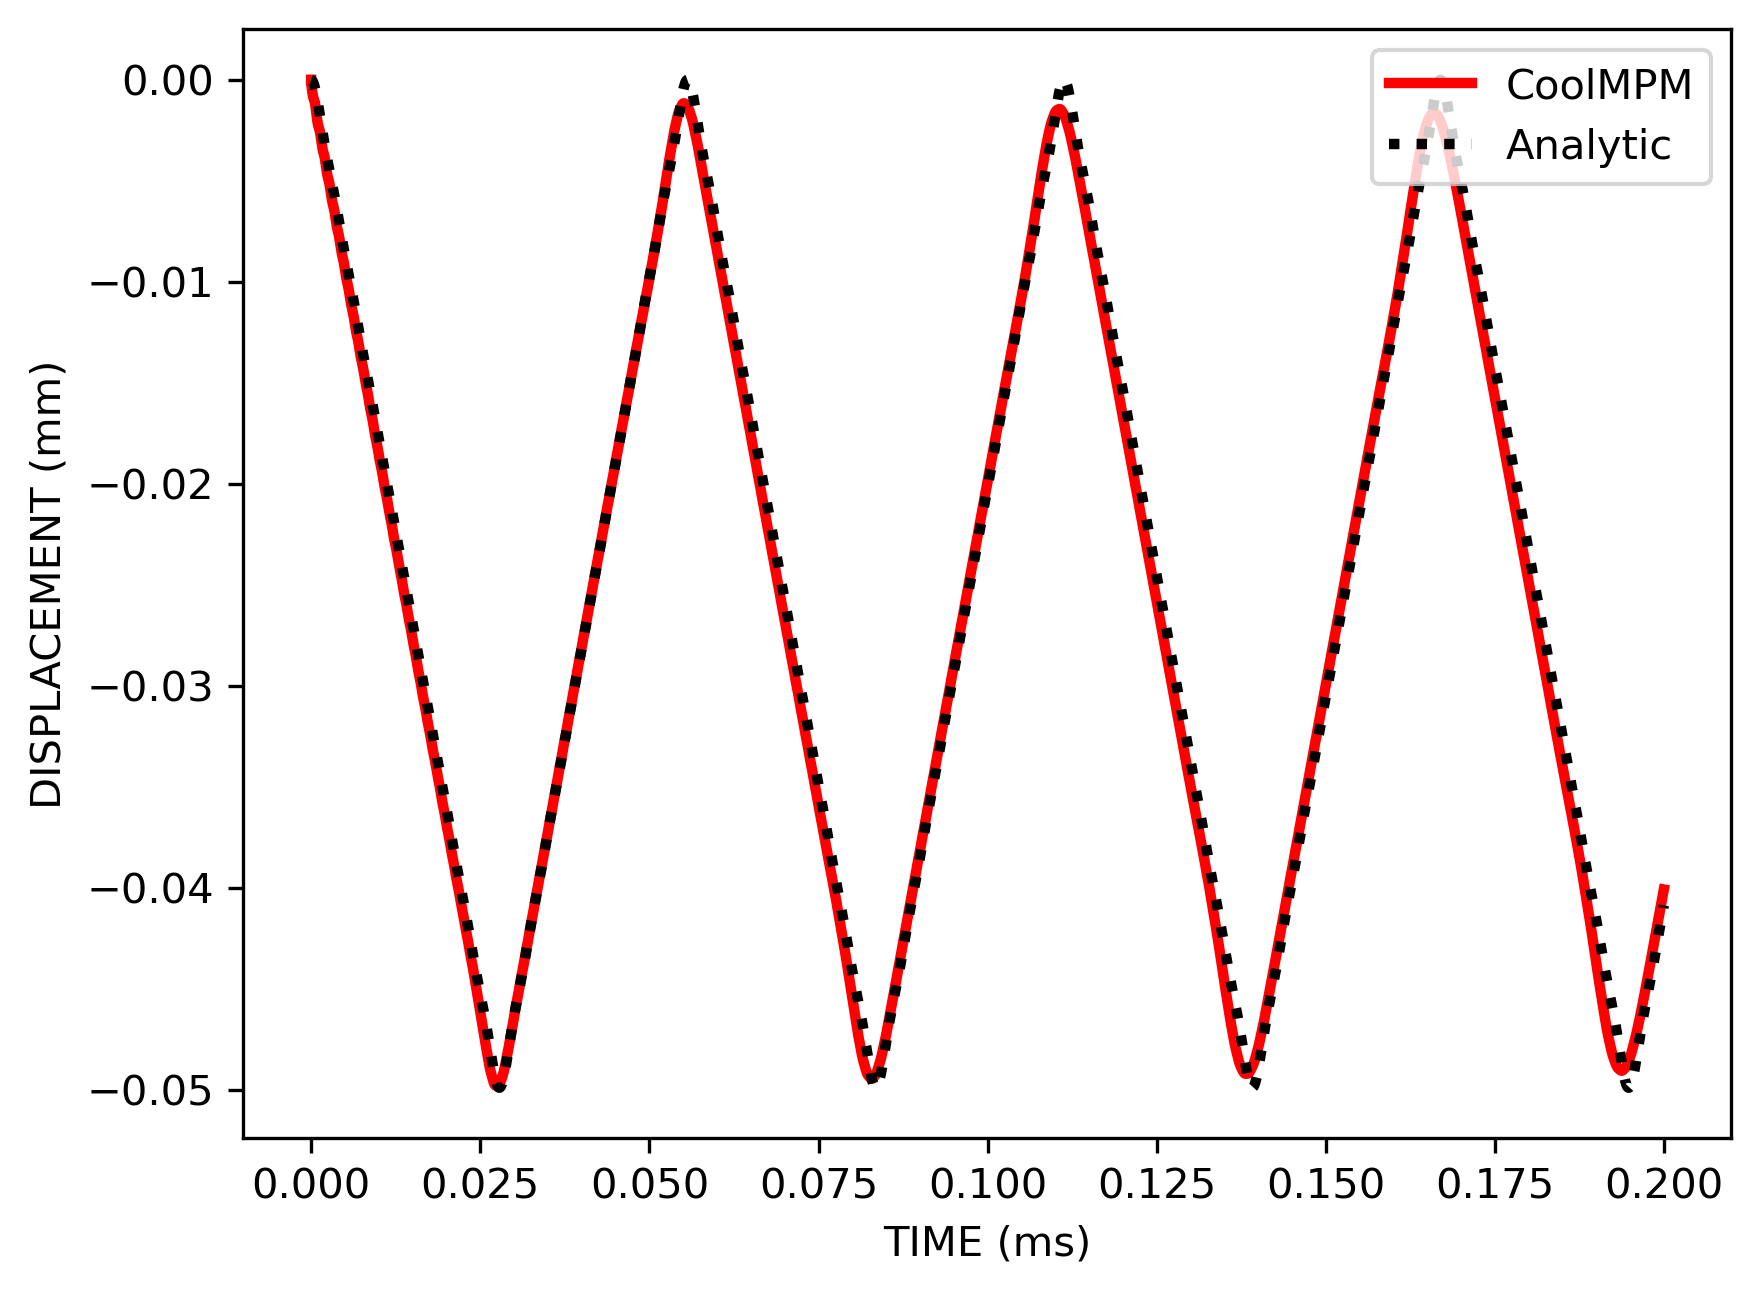

In [15]:
plt.figure(dpi=300)
plt.plot(t_n*1e3, u_ns[:,-1]*1e3, color='r', label='CoolMPM', linewidth=2.5)
plt.plot(t_n*1e3, adispl2*1e3, linestyle=':', color='k', label='Analytic', linewidth=2.5)
plt.ylabel('DISPLACEMENT (mm)')
plt.xlabel('TIME (ms)')
plt.legend(bbox_to_anchor=(1,1),loc='upper right')

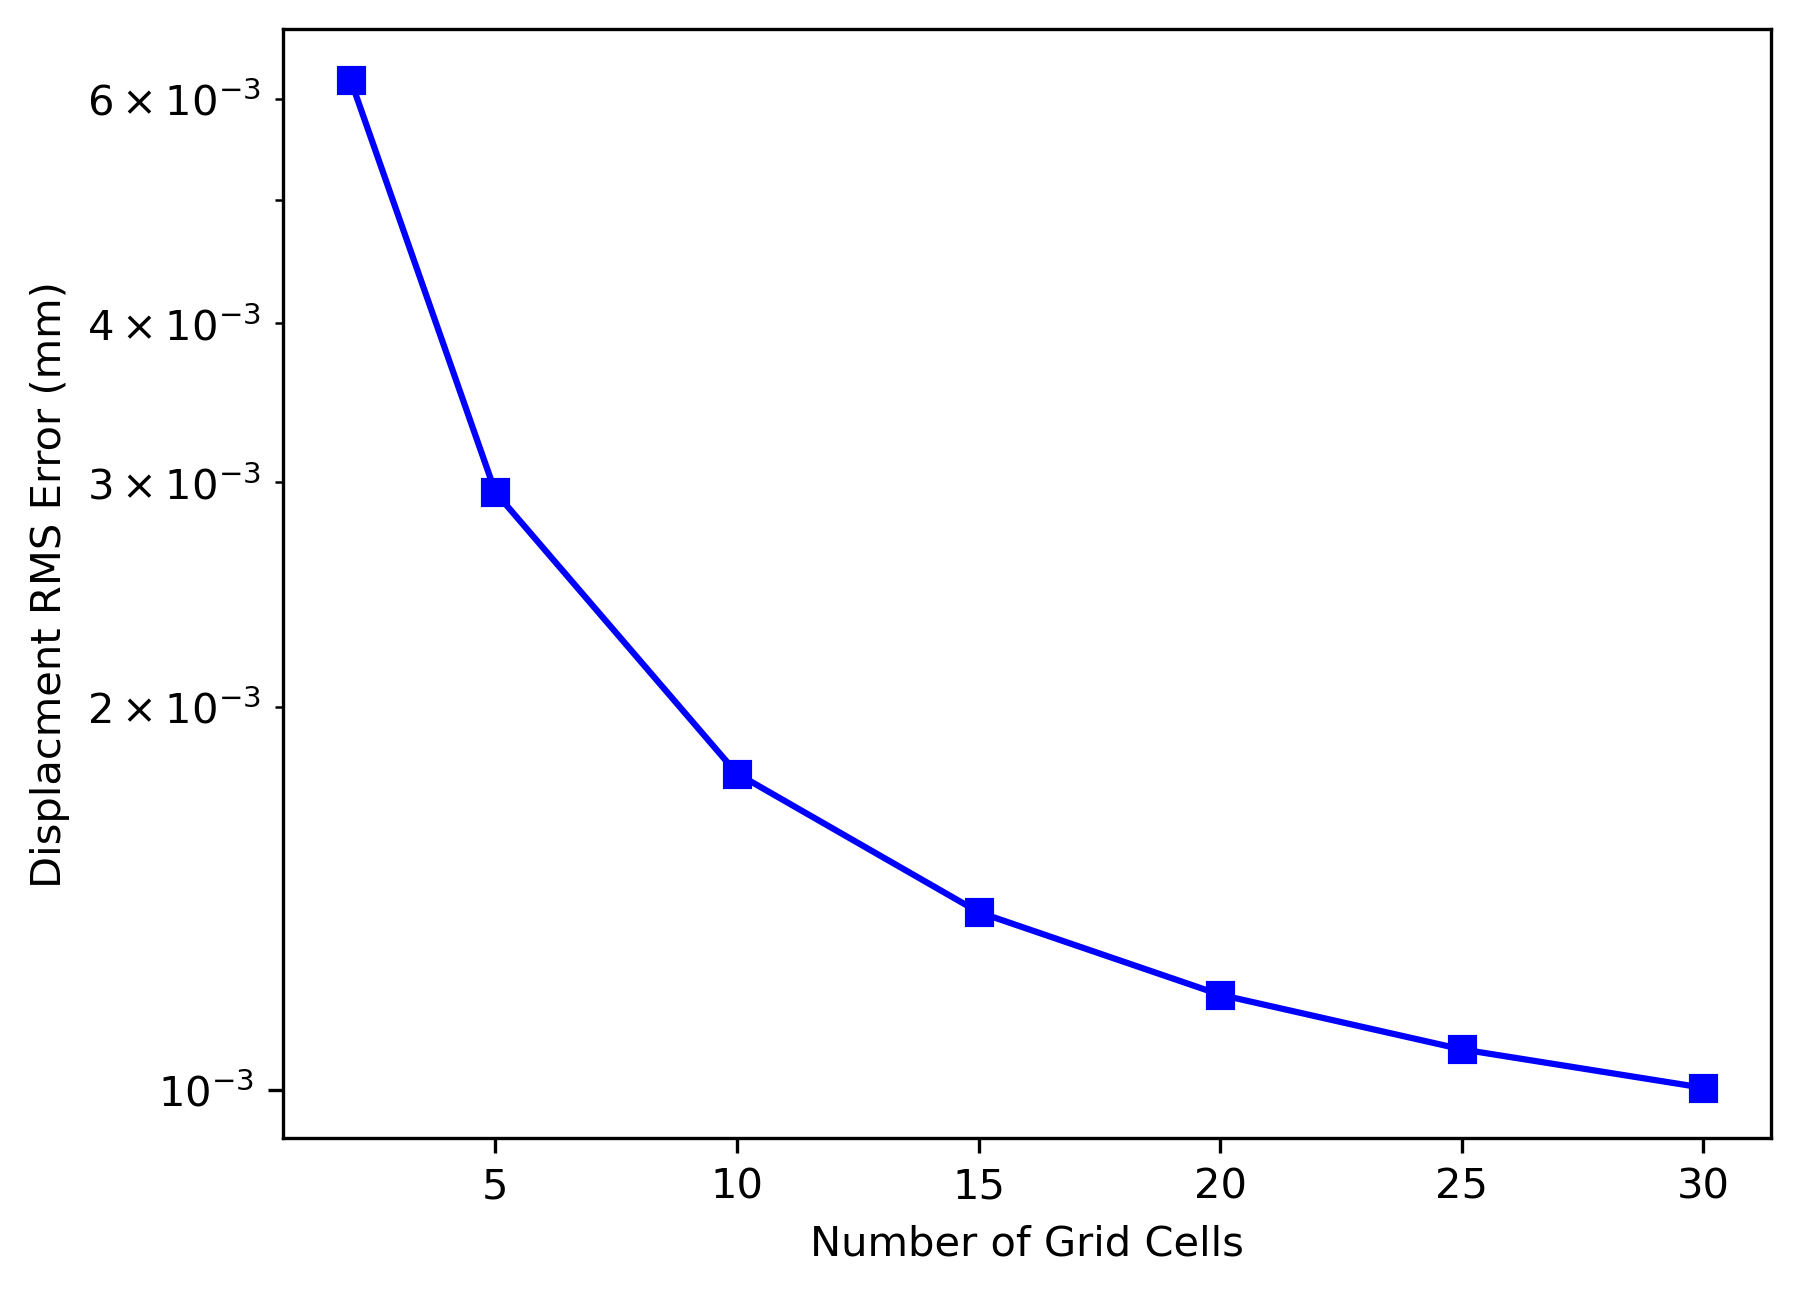

In [16]:
plt.figure(dpi=300)
plt.plot(n_els, np.array(errors)*1e3, 's-b',)
plt.xlabel('Number of Grid Cells') 
plt.ylabel('Displacment RMS Error (mm)')
plt.yscale('log')

# 3 Energy Behavior

## Parameters

In [17]:
E = 5e3 # Pa
nu = 0.3
mu = E/(2*(1+nu))
dlambda = 2*mu*nu/(1 - 2*nu)
Kbulk = dlambda + 2*mu/3 
rho = 1 
gravity = 0 
L = 0.1 # m
A = 1e-4 # m
wavespeed = np.sqrt(E/rho)
n_cells = 32
n_en = 3
n_ppc = 2
dtfactor=0.3
t_tot = 0.05
b = lambda t : 0
tau = lambda t : 0
alpha=0.5
params = dict(E=E,nu=nu,mu=mu,dlambda=dlambda,Kbulk=Kbulk,
              rho=rho,b=b,tau=tau,L=L,A=A,wavespeed=wavespeed,)
grid = initialize_grid(params, n_cells, n_ppc, n_en)
particles = initialize_particles(params, grid)

# Setup Initial velocity 
E_tot_init = 5e-5 # 0.05 mJ
n_particles = particles['n_mp']
E_particle = E_tot_init/(n_particles) # Distribute velocity over each particle
m = particles['mass'][0]
momentum_particle = np.sqrt(2*m*E_particle)
particles['v'][:] = momentum_particle/m


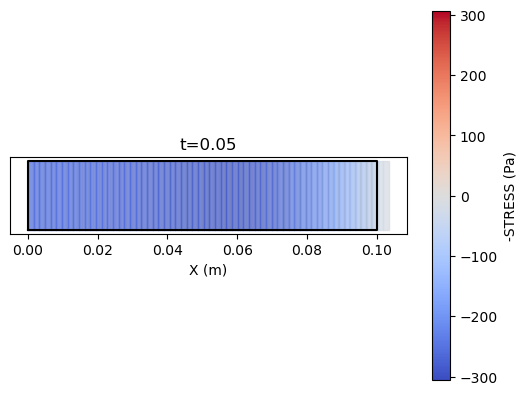

C:\Users\Jacob Nuttall\AppData\Local\Temp\ipykernel_36072\2708477824.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(cmap)


In [18]:
particles = initialize_particles(params, grid)
particles['v'][:] = momentum_particle/m

fig = plt.figure() #dpi=300)
hdisplay = display.display(None, display_id=True)
plt.title('t=0')
ax = plt.gca()

# plot_system(ax, particles,grid,fig,hdisplay,params, draw_nodes=False, draw_rect=False)
# hdisplay.update(fig)
time.sleep(1)

x = y = np.linspace(0,1,10)
x,y = np.meshgrid(x,y)
plt.contourf(x,y,x,cmap='Spectral')
cbar = plt.colorbar()
label='-STRESS (Pa)'
cmap = 'coolwarm'
colormap = cm.get_cmap(cmap)

maxstress = -np.inf

update_stress= True
def plot_func(t, k):
     global fig, particles, maxstress, cbar, update_stress
     ax.clear()
     cbar.ax.clear()
      
     # Update stress
     stress = -np.array(particles['stress'])
     if update_stress:
          maxstress = np.max((np.max(np.abs(stress)), maxstress))
     else: maxstress = maxstress
     stress = -np.array(particles['stress'])
     maxstress = np.max((np.max(np.abs(stress)), maxstress))
     norm = mcolors.Normalize(-maxstress, maxstress)   
     sm = cm.ScalarMappable(cmap=colormap, norm=norm)
     plt.colorbar(sm, cbar.ax)     
     plt.sca(ax)
     cbar.set_label(label)
     
     # Make configuration plot
     ax.set_title('t='+str(round(t,3)))
     plot_configuration(
        ax,
        particles, 
        grid, fig, 
        hdisplay, params, use_colormap=True, 
        cmin=-maxstress, cmax=maxstress, 
        Qp=stress, cbar=cbar, cmap='coolwarm', label=label,
        show_labels=False, draw_nodes=False, draw_rect=False) 

     ax.set_xlabel('X (m)')
     ax.set_xticks(np.linspace(0,L,6))
     draw_rectangle(ax, 0,L,-0.5*np.sqrt(A),0.5*np.sqrt(A),color='k')
     ax.set_aspect(2)
     hdisplay.update(fig)
    
grid, particles, particle_history = TotalLagrangianMPM(
     particles, grid, params, SPK_stress, 
     alpha, dtfactor, t_tot, plot=True, plot_func=plot_func, nplots=100)
plt.close()

Text(0, 0.5, 'Energy (mJ)')

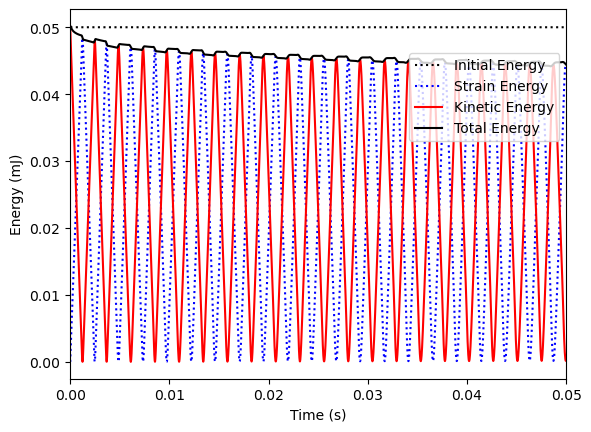

In [19]:
defgrad = particle_history['defgrad']
volume = particle_history['ref_volume']
velocity = particle_history['v']
mass = particle_history['mass']
ts = particle_history['t'][:,0]

# Get total kinetic / Strain energy
U = volume * Strain_Energy_Density(defgrad, params)
T = 0.5 * mass * velocity**2
U = U.sum(axis=1)
T = T.sum(axis=1)

plt.plot(ts, ts*0 + E_tot_init*1e3, color='k', label='Initial Energy', linestyle=':')
plt.plot(ts, U*1e3,  color='b', label='Strain Energy', linestyle=':')
plt.plot(ts, T*1e3,  color='r', label='Kinetic Energy', )
plt.plot(ts, (U+T)*1e3, color='k', label='Total Energy')
plt.xlim([0,0.05])
plt.legend(bbox_to_anchor=(1,0.9), loc='upper right')
plt.xlabel('Time (s)')
plt.ylabel('Energy (mJ)')